# AU 111 150 Ang cube gold substrate evaluation

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import datetime, io, os, shutil, sys, tarfile
import os.path
from glob import glob
from pprint import pprint
from tabulate import tabulate
import numpy as np
import pandas as pd
import ruamel.yaml as yaml
import ase, ase.io
from ase.io import read, write
from ase.io import NetCDFTrajectory
from asap3.analysis.rdf import RadialDistributionFunction

In [4]:
import matplotlib.pyplot as plt
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import nglview as nv
import ipywidgets # just for jupyter notebooks
from IPython.display import Image

In [5]:
from fireworks import Firework, Workflow
from fireworks import LaunchPad
from fireworks.utilities.filepad import FilePad 
from fireworks.utilities.wfb import WorkflowBuilder

fp = FilePad(
   host="localhost",
   port=27018,
   database="fireworks-jhoermann",
   username="fireworks",
   password="fireworks")

In [6]:
 from sympy.ntheory.factor_ import factorint

In [7]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc("font", size=MEDIUM_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (8,5) # the standard figure size

plt.rcParams["lines.linewidth"] = 4
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"]=1

## Definitions

In [8]:
def read_rdf(rdf_data, format='ovito', interval=None):
  """Reads rdf from input string into pandas.DataFrame

  Parameters
  ----------
  rdf_data: str
      input
  format: str
      'ovito' or 'plain'
  interval:
      overrides distances in file

  Returns
  -------
  pandas.Dataframe
      Data in 3-columns: bin index, corresponding distance and count
  """
  rdf_file = io.StringIO(rdf_data.decode())
  if format == 'ovito':
    # format is ovito 3.0.0-dev234 coordination analysis text output
    df = pd.read_csv(rdf_file,
      delim_whitespace=True,header=None,skiprows=3,index_col=0,
      names=['bin','distance','weight'])
  elif format == 'plain':
    df = pd.read_csv(rdf_file,
      delim_whitespace=True,header=None,skiprows=0,
      names=['distance','weight'])
    df.index.name = 'bin'

  if interval is not None:
    try:
      df.distance = np.linspace(interval[0],interval[1],df.shape[0]+1)[:-1]
    except:
      logger.exception(
        "Could not create grid points from specified interval {}".format(
          interval))
      raise ValueError()

  return df


In [9]:
# Creates four polar axes, and accesses them through the returned array
#fig, axes = plt.subplots(2, 2, subplot_kw=dict(polar=True))
def plotThermo(thermo, axes=None, legend=None, title=None):
    global line_list, label_list
    if axes is None:
        fig, axes = plt.subplots(5, 3, figsize=(20,20)) # constrained_layout=True)
        line_list = []
        label_list = []
    else:
        fig = axes[0,0].get_figure()
        
    l = axes[0, 0].plot(thermo["Step"], thermo["TotEng"])[0]
    axes[0, 1].plot(thermo["Step"], thermo["PotEng"])
    axes[0, 2].plot(thermo["Step"], thermo["KinEng"])

    axes[1, 0].plot(thermo["Step"], thermo["Temp"])
    axes[1, 1].plot(thermo["Step"], thermo["Press"])
    axes[1, 2].plot(thermo["Step"], thermo["Enthalpy"])

    axes[2, 0].plot(thermo["Step"], thermo["E_bond"])
    axes[2, 1].plot(thermo["Step"], thermo["E_angle"])
    axes[2, 2].plot(thermo["Step"], thermo["E_dihed"])

    axes[3, 0].plot(thermo["Step"], thermo["E_pair"])
    axes[3, 1].plot(thermo["Step"], thermo["E_vdwl"])
    axes[3, 2].plot(thermo["Step"], thermo["E_coul"])
    
    axes[4, 0].plot(thermo["Step"], thermo["E_long"])
    axes[4, 1].plot(thermo["Step"], thermo["Volume"])

    axes[0,0].set_title("Total Energy")
    axes[0,1].set_title("Potential Energy")
    axes[0,2].set_title("Kinetic Energy")

    axes[1,0].set_title("Temperature")
    axes[1,1].set_title("Pressure")
    axes[1,2].set_title("Enthalpy")

    axes[2, 0].set_title("E_bond")
    axes[2, 1].set_title("E_angle")
    axes[2, 2].set_title("E_dihed")

    axes[3, 0].set_title("E_pair")
    axes[3, 1].set_title("E_vdwl")
    axes[3, 2].set_title("E_coul")
    
    axes[4, 0].set_title("E_long")
    axes[4, 1].set_title("Volume")
    #axes[1, 1].scatter(x, y)

    axes[0,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[0,1].set_ylabel("$V$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[0,2].set_ylabel("$K$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[1,0].set_ylabel("$T$ [ K ]")
    axes[1,1].set_ylabel("$P$ [ atm ]")
    axes[1,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[2,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[2,1].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[2,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[3,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[3,1].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[3,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    
    axes[4,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[4,1].set_ylabel("$V$ [ $ \mathrm{\AA^3} $ ]")
    #axes[4,1].set_visible(False)
    axes[4,2].set_visible(False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if legend is not None:
        #axes[0,0].legend()
        line_list.append(l)
        label_list.append(legend)
        fig.legend(line_list,label_list,loc="lower right", framealpha=1)
        
    if title is not None:
        fig.suptitle(title)
    
    return fig, axes

line_list = []
label_list = []

In [10]:
# plot function for 
# 'Step', 'TotEng', 'KinEng', 'PotEng', 'Temp', 'Press', 'Enthalpy',
#       'E_bond', 'E_angle', 'E_dihed', 'E_impro', 'E_pair', 'E_vdwl', 'E_coul',
#       'E_long', 'E_tail', 'Volume', 'Pxx', 'Pyy', 'Pzz', 'Pxy', 'Pxz', 'Pyz'
def plotThermoWithPressureTensor(thermo, axes=None, legend=None, title=None):
    global line_list, label_list
    if axes is None:
        fig, axes = plt.subplots(7, 3, figsize=(20,40)) # constrained_layout=True)
        line_list = []
        label_list = []
    else:
        fig = axes[0,0].get_figure()
    
    fig, axes = plotThermo(thermo, axes, legend, title)
    
    axes[5, 0].plot(thermo["Step"], thermo["Pxx"])
    axes[5, 1].plot(thermo["Step"], thermo["Pyy"])
    axes[5, 2].plot(thermo["Step"], thermo["Pzz"])
    
    axes[6, 0].plot(thermo["Step"], thermo["Pxy"])
    axes[6, 1].plot(thermo["Step"], thermo["Pyz"])
    axes[6, 2].plot(thermo["Step"], thermo["Pyz"])
    
    axes[5, 0].set_title("Pressure tensor component xx")
    axes[5, 1].set_title("Pressure tensor component yy")
    axes[5, 2].set_title("Pressure tensor component zz")

    axes[6, 0].set_title("Pressure tensor component xy")
    axes[6, 1].set_title("Pressure tensor component xz")
    axes[6, 2].set_title("Pressure tensor component yz")
    
    axes[5, 0].set_ylabel("$P_{xx}$ [ atm ]")
    axes[5, 1].set_ylabel("$P_{yy}$ [ atm ]")
    axes[5, 2].set_ylabel("$P_{zz}$ [ atm ]")
    
    axes[6, 0].set_ylabel("$P_{xy}$ [ atm ]")
    axes[6, 1].set_ylabel("$P_{xz}$ [ atm ]")
    axes[6, 2].set_ylabel("$P_{yz}$ [ atm ]")
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if legend is not None:
        fig.legend(line_list,label_list,loc="lower right", framealpha=1)
        
    if title is not None:
        fig.suptitle(title)
    
    return fig, axes

line_list = []
label_list = []

## Evaluation

### All system-related files

In [163]:
query = {
    'metadata.sb_name':  'AU_111_150Ang_cube'
}

In [164]:
files = fp.get_file_by_query(query)

In [165]:
len(files)

18

In [166]:
file_dict = { d["identifier"]: { 
        "metadata": d["metadata"],
        "content":  c } for c, d in files }
    

In [167]:
pprint(list(file_dict.keys()))

['substrate/AU/111/150Ang/cube/initial_config.lammps',
 'substrate/AU/111/150Ang/cube/minimization_fixed_box/default.lammps',
 'substrate/AU/111/150Ang/cube/minimization_fixed_box/log.lammps',
 'substrate/AU/111/150Ang/cube/minimization_fixed_box/thermo.out',
 'substrate/AU/111/150Ang/cube/minimization_relaxed_box/default.lammps',
 'substrate/AU/111/150Ang/cube/minimization_relaxed_box/log.lammps',
 'substrate/AU/111/150Ang/cube/minimization_relaxed_box/thermo.out',
 'substrate/AU/111/150Ang/cube/equilibration_nvt/thermo_ave.out',
 'substrate/AU/111/150Ang/cube/equilibration_nvt/default.lammps',
 'substrate/AU/111/150Ang/cube/equilibration_nvt/log.lammps',
 'substrate/AU/111/150Ang/cube/equilibration_nvt/thermo.out',
 'substrate/AU/111/150Ang/cube/equilibration_npt/thermo_ave.out',
 'substrate/AU/111/150Ang/cube/equilibration_npt/default.lammps',
 'substrate/AU/111/150Ang/cube/equilibration_npt/log.lammps',
 'substrate/AU/111/150Ang/cube/equilibration_npt/thermo.out',
 'substrate/AU/11

In [168]:
print(files[0][0][:1000].decode())

LAMMPS data file via write_data, version 22 Aug 2018, timestep = 0

201600 atoms
11 atom types

0.0000000000000000e+00 1.5041221896009648e+02 xlo xhi
0.0000000000000000e+00 1.4972506052762179e+02 ylo yhi
0.0000000000000000e+00 1.5033767996995965e+02 zlo zhi

Masses

1 1.008
2 1.008
3 12.011
4 12.011
5 15.9994
6 15.9994
7 32.06
8 1.008
9 15.9994
10 22.9898
11 196.966

Atoms # full

1 0 11 0.0000000000000000e+00 1.4839519686676181e+02 1.4722964285216142e+02 0.0000000000000000e+00 0 0 0
2 0 11 0.0000000000000000e+00 1.4551373673342664e+02 1.4722964285216142e+02 0.0000000000000000e+00 0 0 0
3 0 11 0.0000000000000000e+00 1.4839519686676184e+02 1.4889325463580167e+02 2.3527023469477371e+00 0 0 0
4 0 11 0.0000000000000000e+00 1.4263227660009147e+02 1.4722964285216142e+02 0.0000000000000000e+00 0 0 0
5 0 11 0.0000000000000000e+00 1.3975081646675628e+02 1.4722964285216142e+02 0.0000000000000000e+00 0 0 0
6 0 11 0.0000000000000000e+00 1.4551373673342664e+02 1.4889325463580167e+02 2.3527023469477

### Thermo .out files

In [112]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.sb_name':  'AU_111_150Ang_cube'
}

In [113]:
files = fp.get_file_by_query(query)

In [71]:
len(files)

3

In [72]:
files[0][1]["metadata"]["step"]

'equilibration_nvt'

In [73]:
file_dict = { d["metadata"]["step"]: { 
        "metadata": d["metadata"],
        "content":  c } for c, d in files }
    

In [74]:
pprint(list(file_dict.keys()))

['equilibration_nvt', 'minimization_fixed_box', 'minimization_relaxed_box']


In [75]:
files[0][1]["metadata"]

{'coulomb_cutoff': 8.0,
 'ewald_accuracy': 0.0001,
 'force_field': None,
 'machine': 'NEMO',
 'neigh_check': 1,
 'neigh_delay': 2,
 'neigh_every': 1,
 'pbc': 111,
 'pressure': 1,
 'pressure_unit': 'atm',
 'sb_area': 2.25e-16,
 'sb_area_unit': 'm^2',
 'sb_base_length': 150,
 'sb_base_length_unit': 'Ang',
 'sb_crystal_plane': 111,
 'sb_measures': [1.50412e-08, 1.49725e-08, 1.50338e-08],
 'sb_measures_unit': 'm',
 'sb_name': 'AU_111_150Ang_cube',
 'sb_normal': 2,
 'sb_shape': 'cube',
 'sb_thickness': 1.5e-08,
 'sb_thickness_unit': 'm',
 'sb_volume': 3.375e-23,
 'sb_volume_unit': 'm^3',
 'skin_distance': 3.0,
 'state': 'minimized and nvt-equilibrated with eam potential',
 'step': 'equilibration_nvt',
 'substrate': 'AU',
 'system_name': 'AU_111_150Ang_cube',
 'temperature': 298,
 'temperature_unit': 'K',
 'use_barostat': 0,
 'use_dpd_tstat': 0}

In [76]:
title_pattern = '''{substrate:} ({sb_crystal_plane:}) 
    {sb_base_length:} {sb_base_length_unit:} {sb_shape:} substrate.'''

In [77]:
legend_pattern = '''{step:}.'''

In [78]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"],
        sb_base_length = doc["metadata"]["sb_base_length"],
        sb_base_length_unit = doc["metadata"]["sb_base_length_unit"],
        sb_shape = doc["metadata"]["sb_shape"])

    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend = legend_pattern.format(
            step = doc["metadata"]["step"])
    #legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
        
    thermoData.append({'title': title, 'legend': legend, 'data': df})

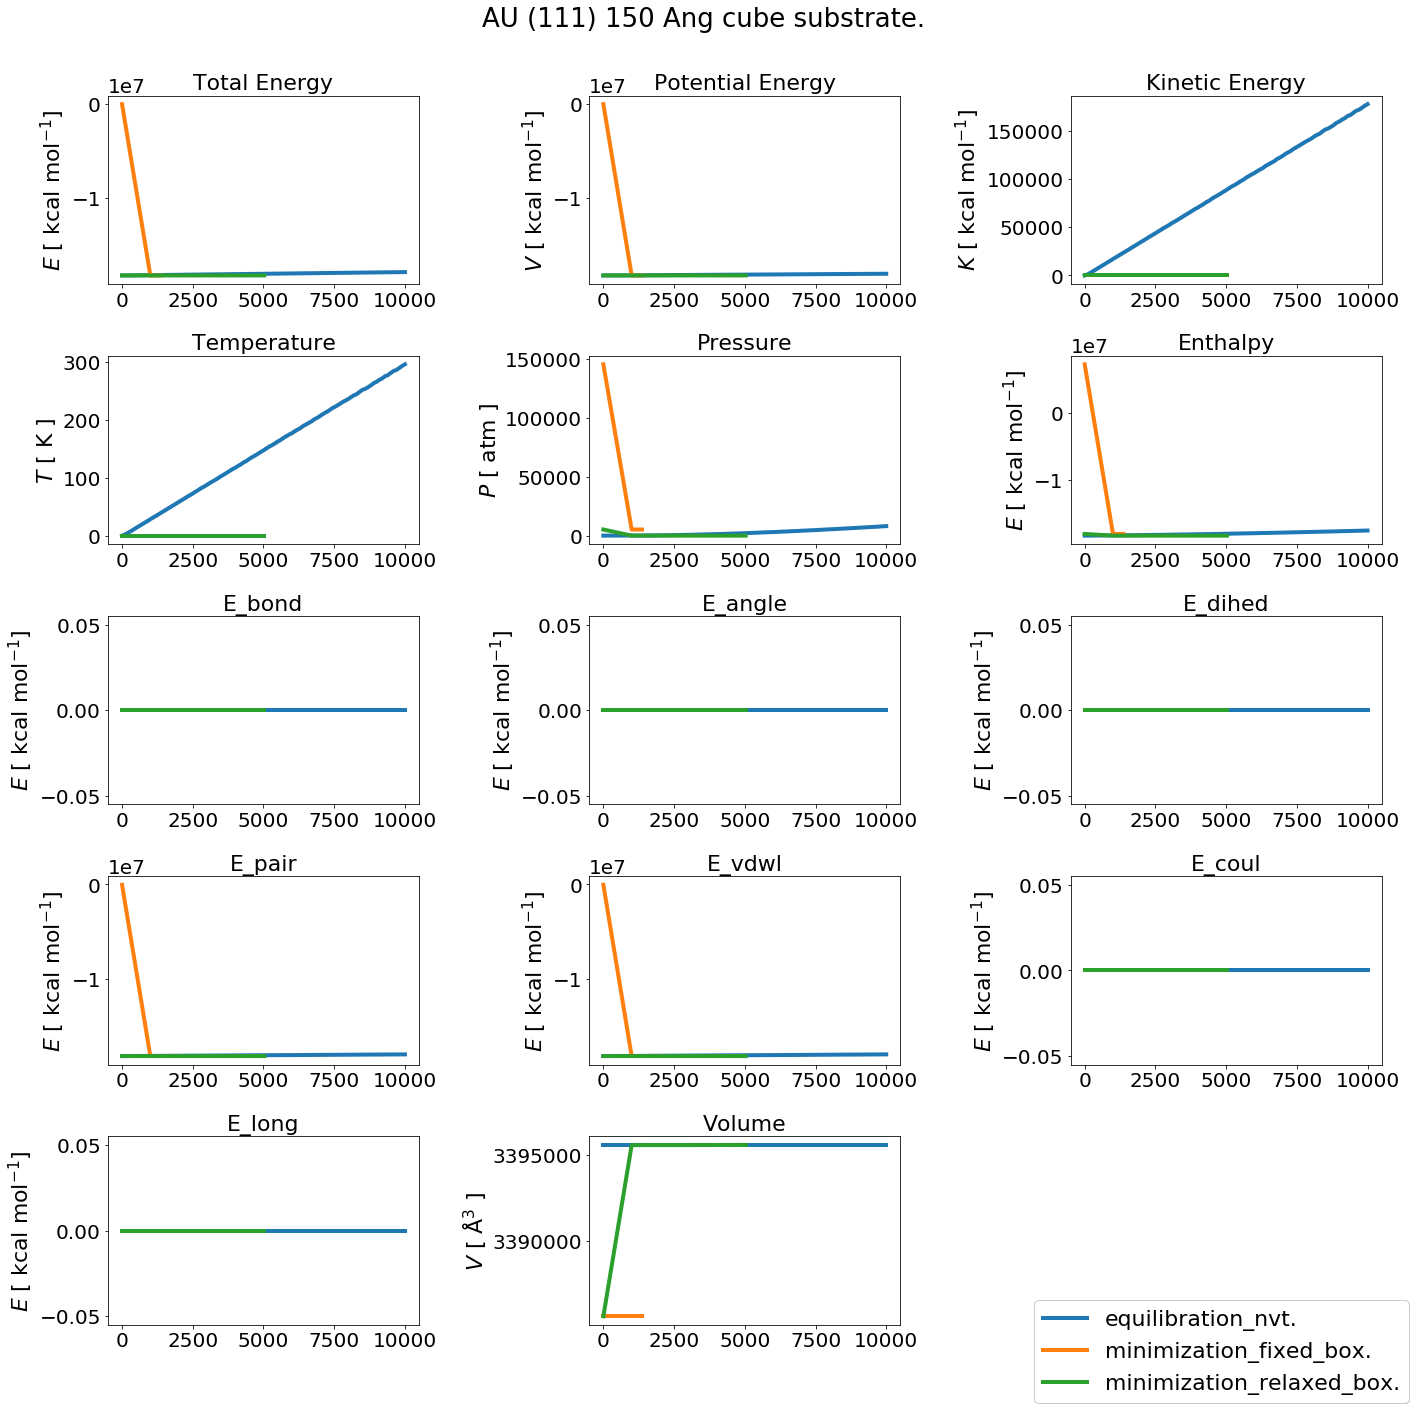

In [79]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermo(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermo(d["data"], axes=ax,
                        legend=d["legend"])

## NVT equilibration

In [80]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.sb_name':  'AU_111_150Ang_cube',
    'metadata.step':    'equilibration_nvt',
}

In [81]:
files = fp.get_file_by_query(query)

In [82]:
len(files)

1

### Thermo .out files

In [83]:
title_pattern = '''{substrate:} ({sb_crystal_plane:}) 
    {sb_base_length:} {sb_base_length_unit:} {sb_shape:} substrate.'''

In [84]:
legend_pattern = '''{step:}.'''

In [85]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"],
        sb_base_length = doc["metadata"]["sb_base_length"],
        sb_base_length_unit = doc["metadata"]["sb_base_length_unit"],
        sb_shape = doc["metadata"]["sb_shape"])

    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend = legend_pattern.format(
            step = doc["metadata"]["step"])
    #legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
        
    thermoData.append({'title': title, 'legend': legend, 'data': df})

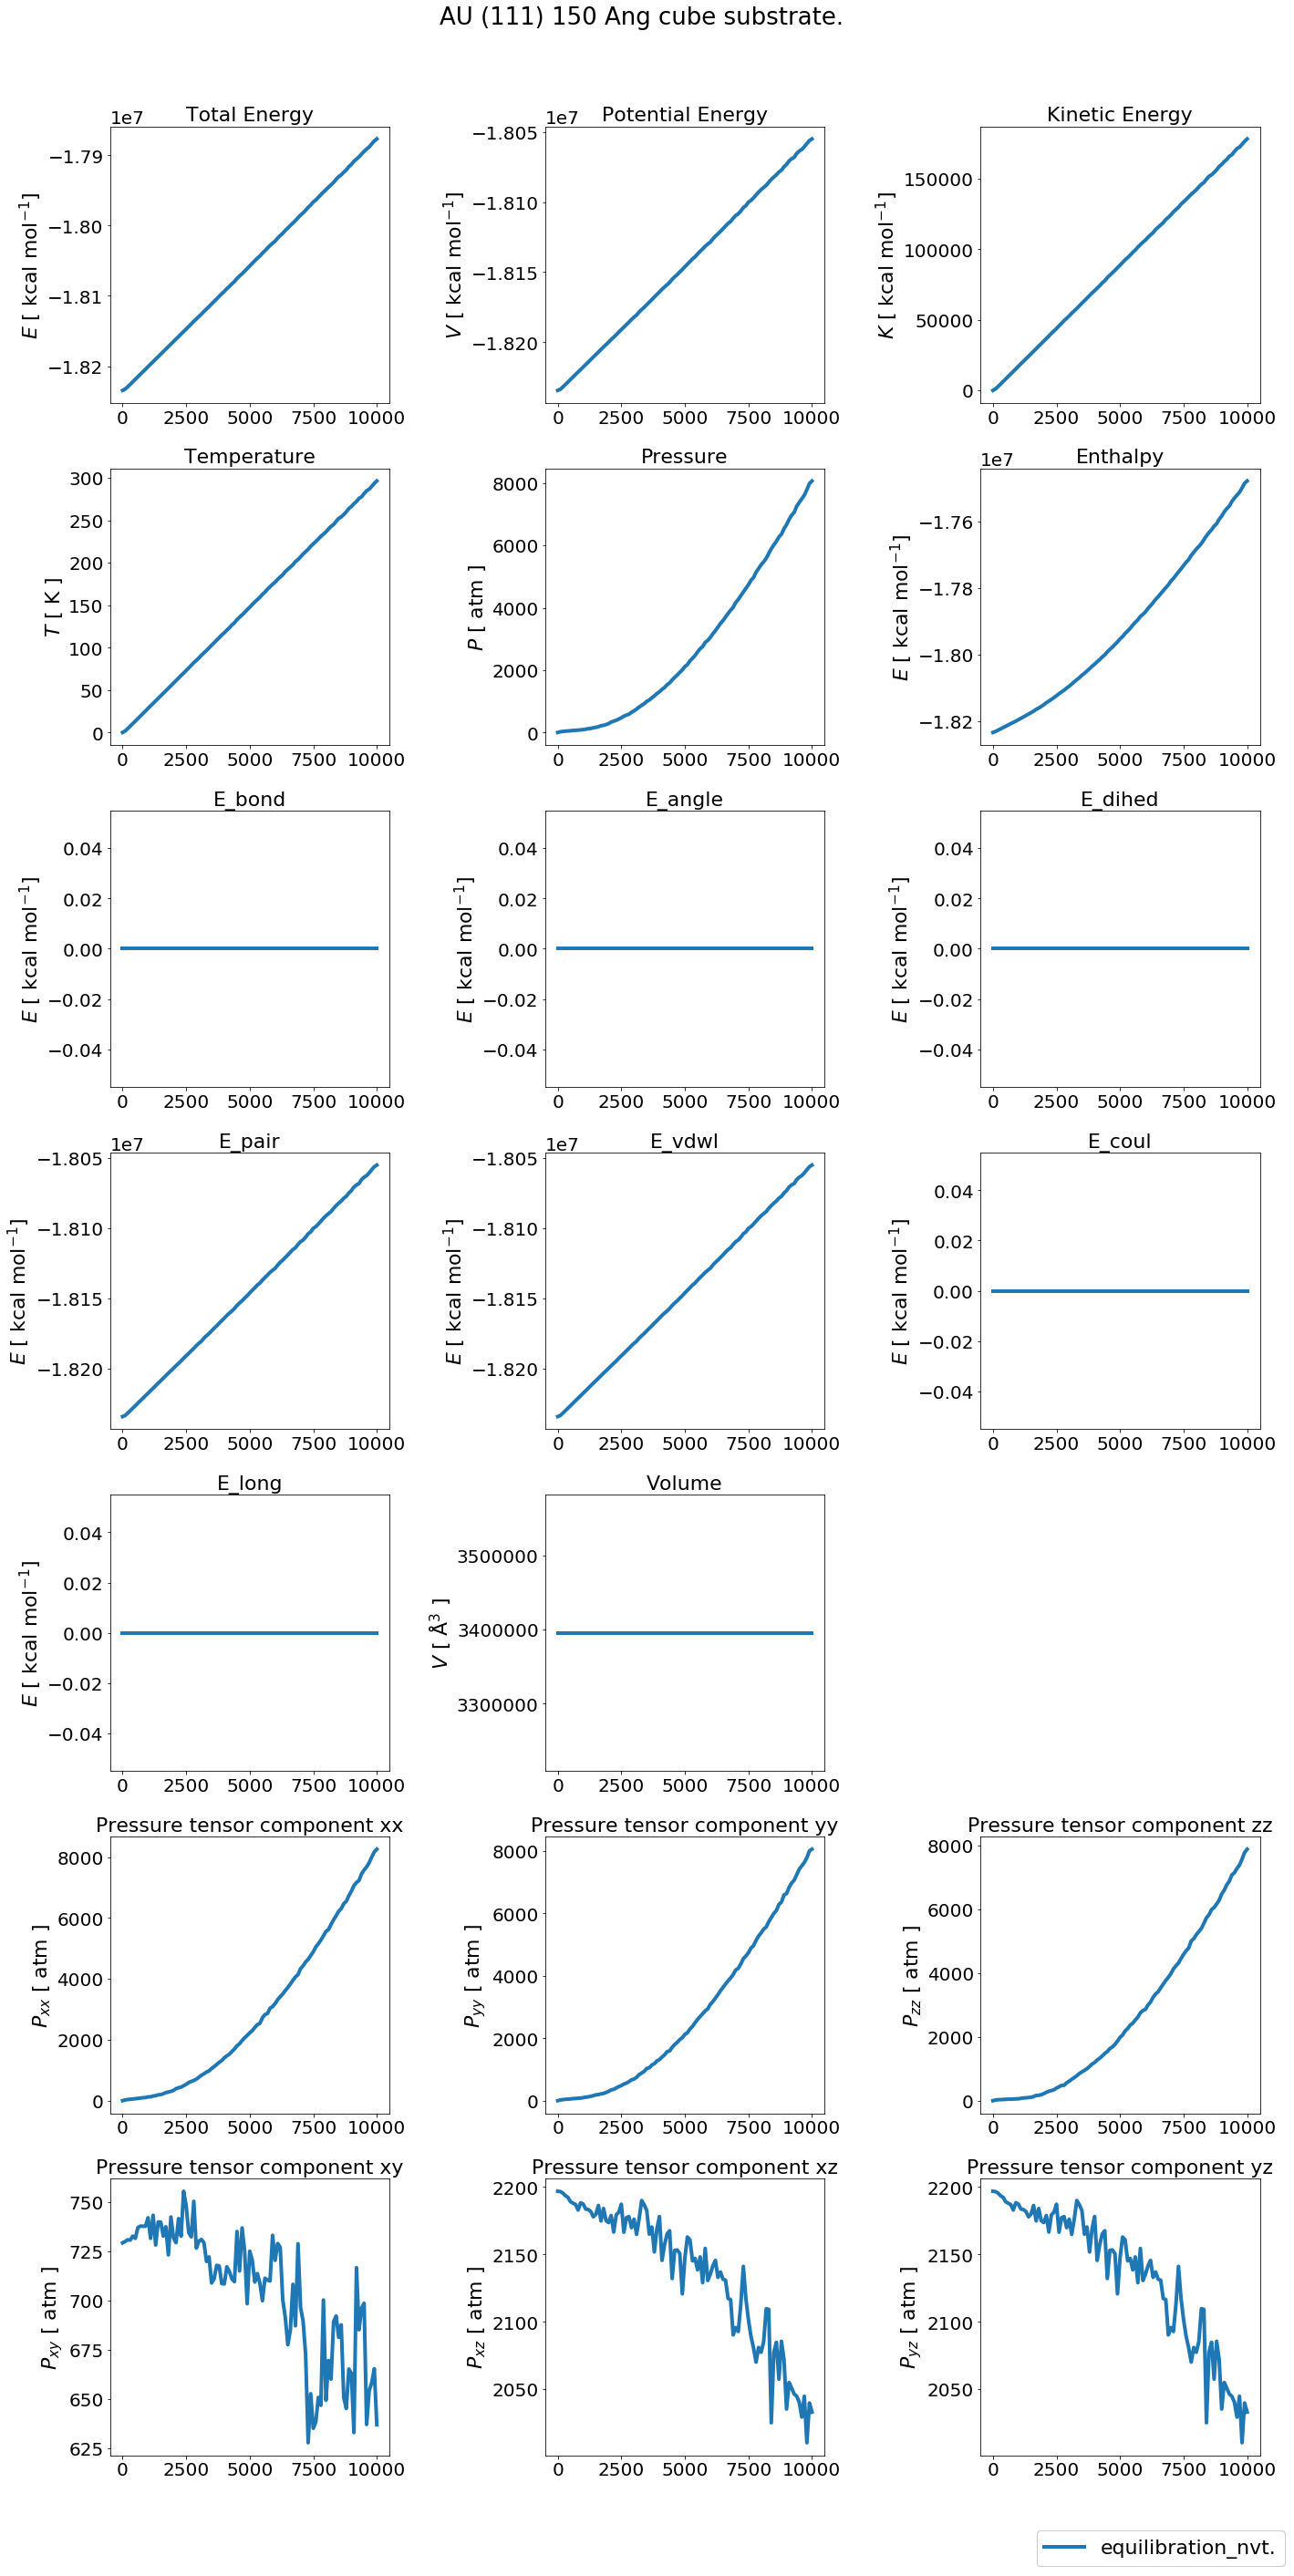

In [86]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermoWithPressureTensor(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermoWithPressureTensor(d["data"], axes=ax,
                        legend=d["legend"])

In [87]:
thermoData[0]["data"]

,Step,TotEng,KinEng,PotEng,Temp,Press,Enthalpy,E_bond,E_angle,E_dihed,...,E_coul,E_long,E_tail,Volume,Pxx,Pyy,Pzz,Pxy,Pxz,Pyz
0,0,-18234347,0.0000,-18234347,0.000000,0.985110,-18234298,0,0,0,...,0,0,0,3395550.5,0.996364,0.976924,0.982042,729.35893,-1110.8597,2196.8708
1,100,-18232517,1049.2083,-18233566,1.745979,22.848591,-18231385,0,0,0,...,0,0,0,3395550.5,24.896208,22.345343,21.304223,730.07482,-1112.4482,2196.6203
2,200,-18229204,2708.2614,-18231912,4.506796,34.831750,-18227479,0,0,0,...,0,0,0,3395550.5,38.748476,35.523046,30.223728,730.92199,-1115.3437,2195.5319
3,300,-18225674,4480.6477,-18230155,7.456210,42.562363,-18223566,0,0,0,...,0,0,0,3395550.5,47.740740,45.031731,34.914618,730.73943,-1115.7316,2193.5893
4,400,-18222108,6273.3076,-18228381,10.439361,48.395489,-18219711,0,0,0,...,0,0,0,3395550.5,55.904395,51.048639,38.233434,732.78482,-1116.1194,2192.3491
5,500,-18218501,8071.4122,-18226573,13.431572,54.397790,-18215807,0,0,0,...,0,0,0,3395550.5,64.609705,55.165979,43.417686,731.63806,-1116.0601,2189.1205
6,600,-18214947,9842.4419,-18224789,16.378729,64.952010,-18211730,0,0,0,...,0,0,0,3395550.5,77.730817,68.381406,48.743806,737.11272,-1115.7160,2188.0266
7,700,-18211356,11639.9270,-18222996,19.369910,68.764949,-18207950,0,0,0,...,0,0,0,3395550.5,87.118078,70.547363,48.629406,737.88394,-1119.0593,2187.0037
8,800,-18207800,13422.6680,-18221223,22.336554,77.071389,-18203983,0,0,0,...,0,0,0,3395550.5,98.223257,81.679166,51.311744,737.78324,-1127.4770,2182.9511
9,900,-18204257,15185.4400,-18219442,25.269969,81.800369,-18200206,0,0,0,...,0,0,0,3395550.5,103.068000,84.511280,57.821828,737.82145,-1130.6189,2188.3113


## NPT equilibration

In [91]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.sb_name':  'AU_111_150Ang_cube',
    'metadata.step':    'equilibration_npt',
}

In [92]:
files = fp.get_file_by_query(query)

In [93]:
len(files)

1

### Thermo .out files

In [94]:
title_pattern = '''{substrate:} ({sb_crystal_plane:}) 
    {sb_base_length:} {sb_base_length_unit:} {sb_shape:} substrate.'''

In [95]:
legend_pattern = '''{step:}.'''

In [96]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"],
        sb_base_length = doc["metadata"]["sb_base_length"],
        sb_base_length_unit = doc["metadata"]["sb_base_length_unit"],
        sb_shape = doc["metadata"]["sb_shape"])

    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend = legend_pattern.format(
            step = doc["metadata"]["step"])
    #legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
        
    thermoData.append({'title': title, 'legend': legend, 'data': df})

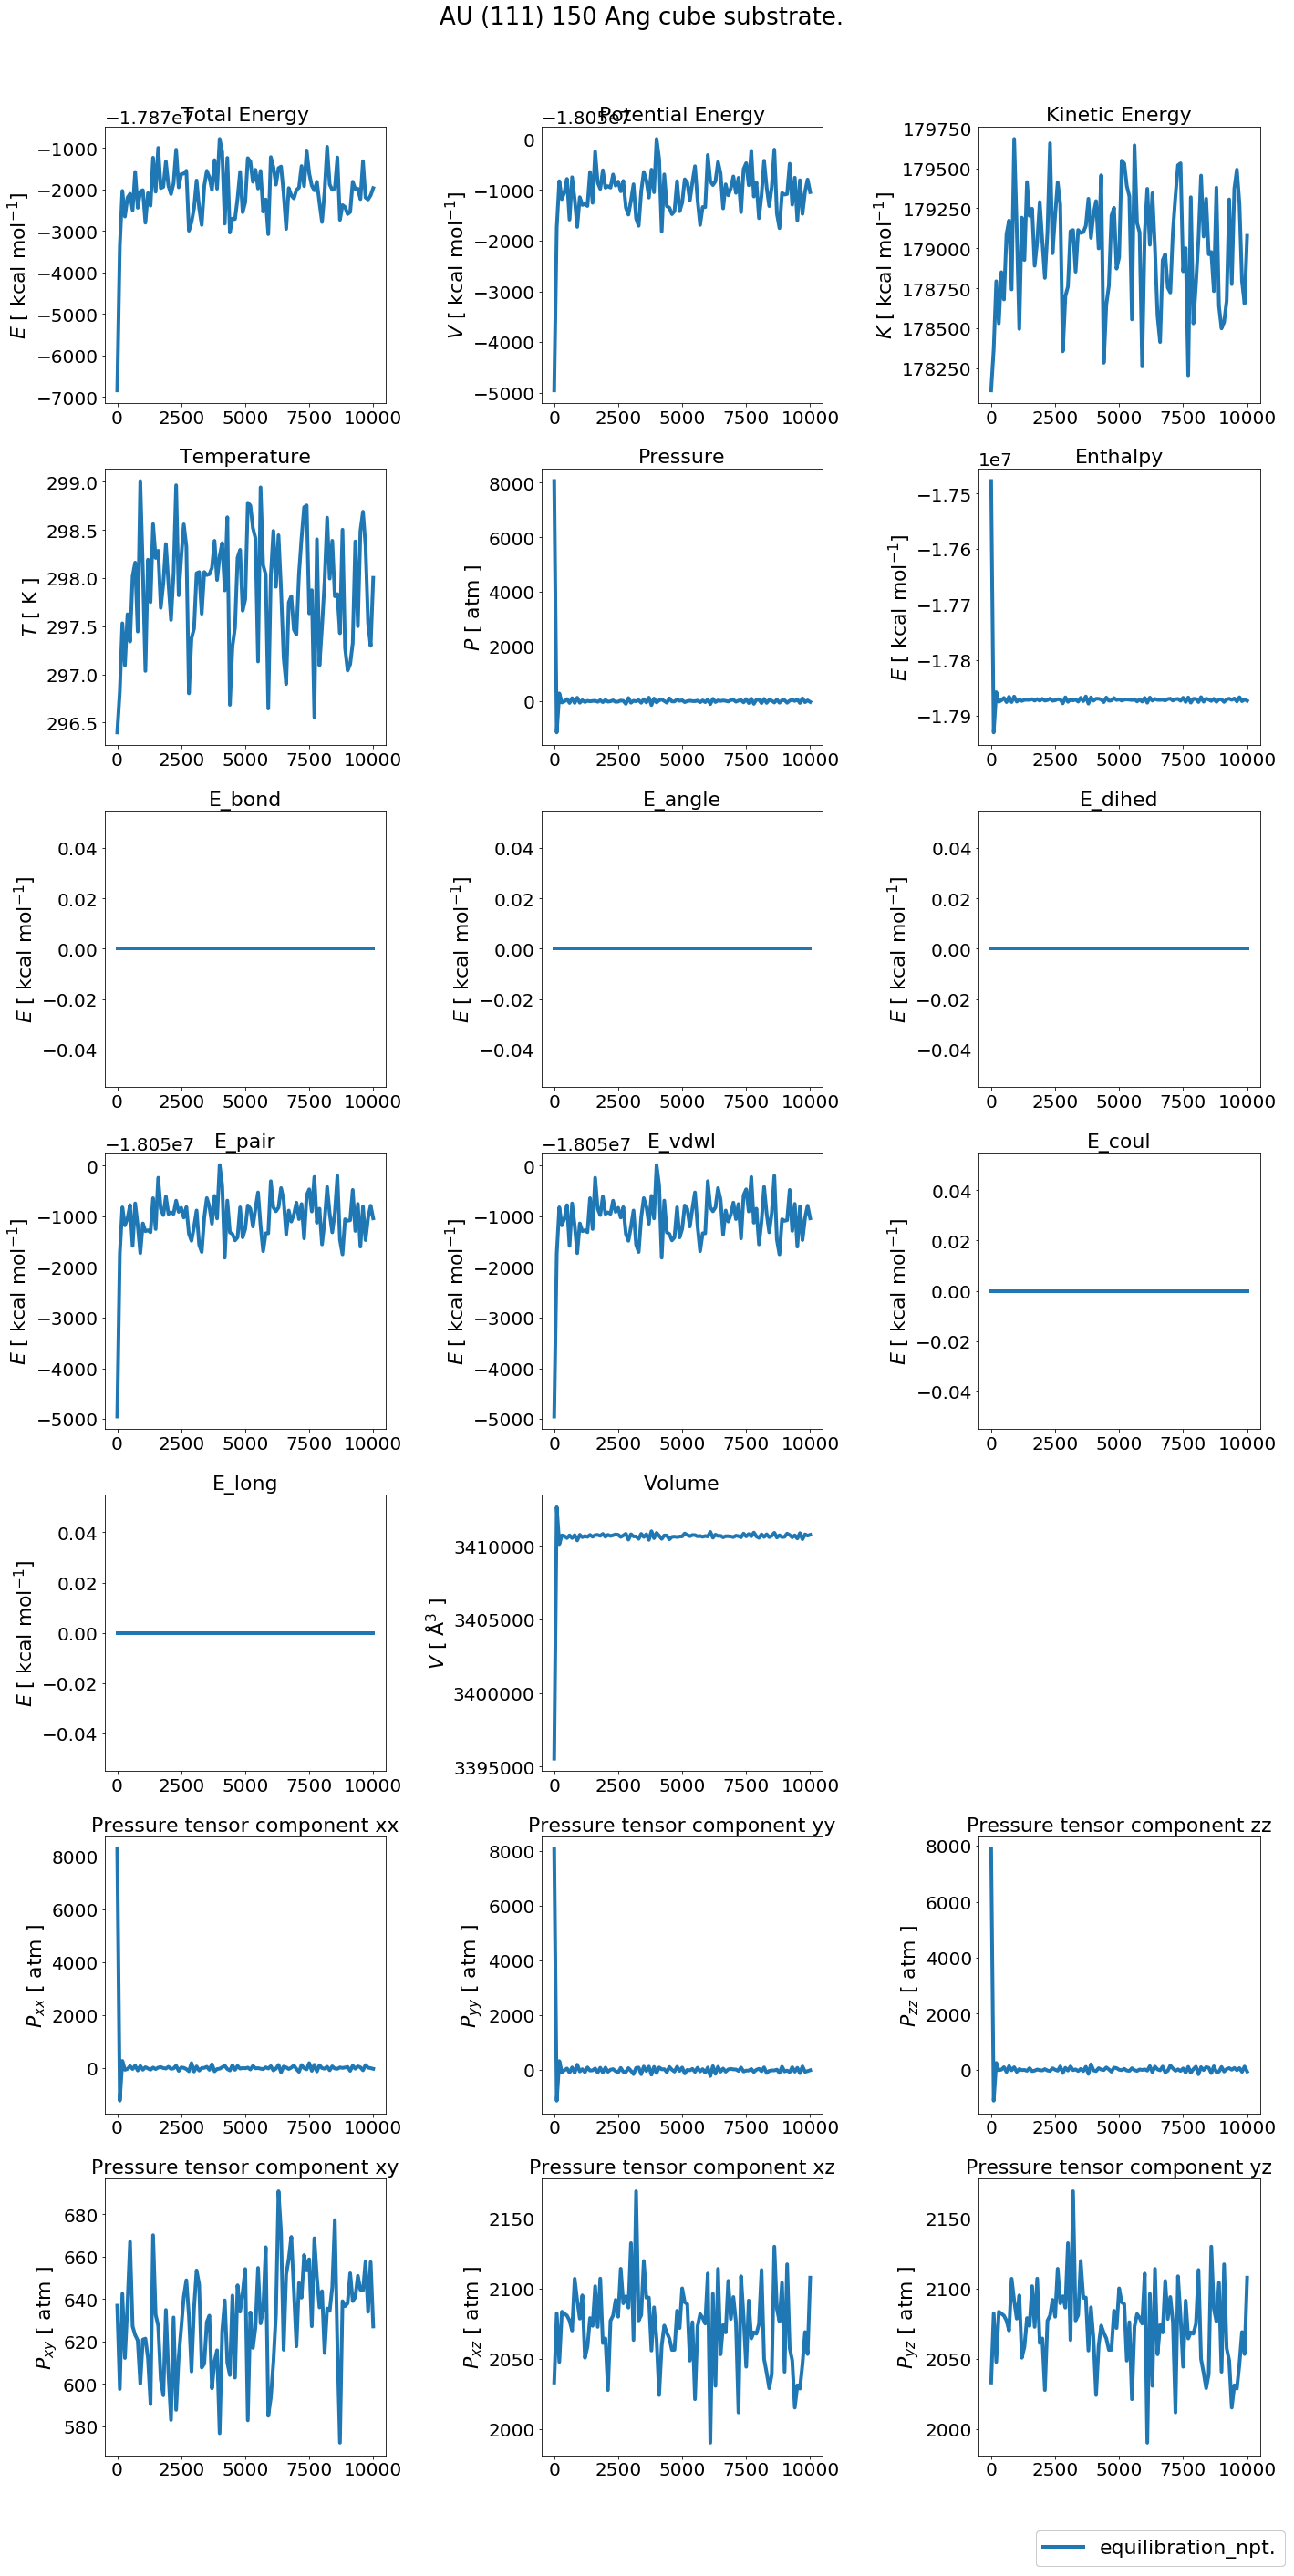

In [97]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermoWithPressureTensor(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermoWithPressureTensor(d["data"], axes=ax,
                        legend=d["legend"])

### RDF

In [134]:
from postprocessing import find_histogram_peak, plot_histogram

In [117]:
query = {
    'identifier': { '$regex': '.*rdf\.txt$'},
    'metadata.sb_name':  'AU_111_150Ang_cube',
    'metadata.step':    'equilibration_npt',
}

In [118]:
files = fp.get_file_by_query(query)

In [119]:
len(files)

2

In [142]:
dataset_names = list(map(lambda d: os.path.basename(d[1]["identifier"]), files))

In [143]:
dataset_names

['fcc_rdf.txt', 'rdf.txt']

In [126]:
df = read_rdf(files[0][0],format='plain')

In [129]:
df.columns

Index(['distance', 'weight'], dtype='object')

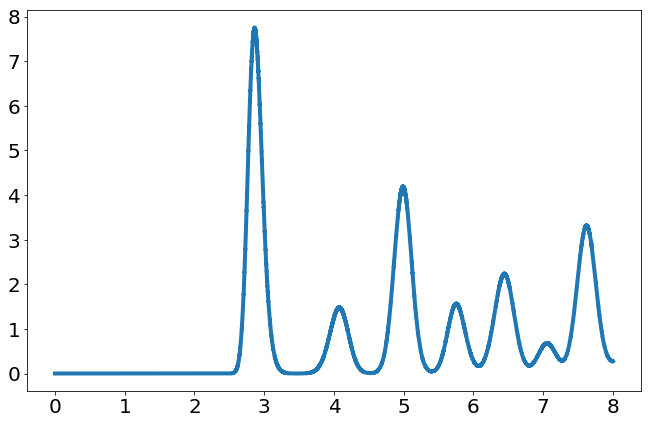

In [130]:
plt.plot(df["distance"],df["weight"])

<BarContainer object of 2500 artists>

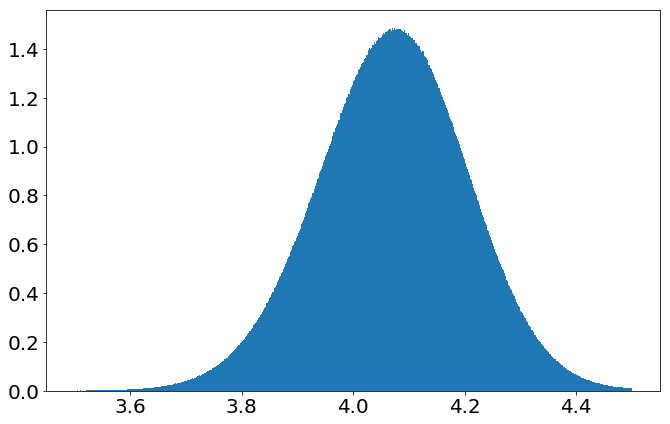

In [136]:
plot_histogram(df,interval=(3.5,4.5))

In [132]:
peak_position = find_histogram_peak(df,interval=(3.5, 4.5))

In [144]:
peak_position = {}
for n, d in zip(dataset_names, files):
    df = read_rdf(d[0],format='plain')

    #plt.plot(df["distance"],df["weight"])
    #plot_histogram(df,interval=(3.5,4.5))

    peak_position[n] = find_histogram_peak(df,interval=(3.5, 4.5))

In [145]:
peak_position

{'fcc_rdf.txt': 4.069966633374355, 'rdf.txt': 4.069797762399628}

### Box measures

In [11]:
query = {
    'identifier': { '$regex': '.*box\.txt$'},
    'metadata.sb_name':  'AU_111_150Ang_cube',
    'metadata.step':    'equilibration_npt',
}

In [12]:
files = fp.get_file_by_query(query)

In [13]:
len(files)

1

In [14]:
cont = files[0][0]
contStream = io.StringIO(cont.decode())
#df = pd.read_csv(contStream,delim_whitespace=True)

In [15]:
cell_measures = np.loadtxt(contStream)

In [16]:
cell_measures

array([[150.65566089, 149.79576577, 150.46143672],
       [150.95783136, 150.03671023, 150.67338143],
       [150.90372647, 150.00144636, 150.65168958],
       [150.92480478, 150.00756962, 150.65070312],
       [150.92816863, 150.00890242, 150.64423451],
       [150.92055351, 150.01357873, 150.64104324],
       [150.91447637, 150.01236515, 150.65644782],
       [150.91526378, 150.0101567 , 150.64980135],
       [150.91383661, 150.02712666, 150.6431272 ],
       [150.91911427, 149.99414501, 150.65492256],
       [150.91857103, 150.0147195 , 150.65167159],
       [150.91747023, 150.01139381, 150.64892691],
       [150.90551653, 150.02453486, 150.6511653 ],
       [150.92250256, 150.00385978, 150.65246452],
       [150.91084235, 150.01425204, 150.65957605],
       [150.92284195, 150.01377927, 150.64230965],
       [150.91857481, 150.00569181, 150.66000534],
       [150.91112608, 150.02744094, 150.64597031],
       [150.92537629, 149.99919368, 150.65739157],
       [150.91471315, 150.03053

In [17]:
t = np.linspace(0,200.0,len(cell_measures))

In [18]:
len(cell_measures)

101

Text(0, 0.5, 'd ($\\AA$)')

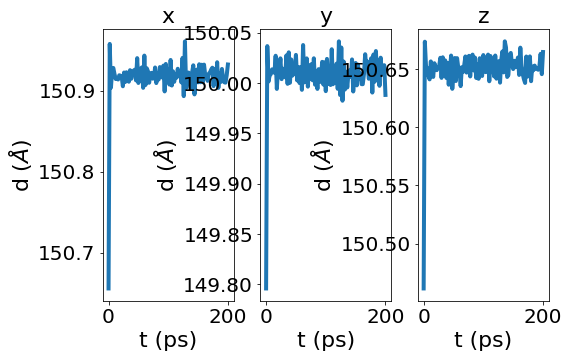

In [19]:
plt.subplot(131)
plt.plot(t, cell_measures[:,0], label='x' )
plt.title('x')
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")
plt.subplot(132)
plt.plot(t, cell_measures[:,1], label='y' )
plt.title('y')
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")
plt.subplot(133)
plt.plot(t, cell_measures[:,2], label='z' )
plt.title('z')
#plt.legend()
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")

In [226]:
N_atoms = 201600

In [225]:
N_atoms /2

102375.0

In [22]:
mean_measures = np.mean(cell_measures[100:,:],axis=0)

In [23]:
# relation between plane_spacings in this orientation and lattice constant:
plane_spacing_to_lattice_constant = np.array(
    [np.sqrt(2), np.sqrt(6), np.sqrt(3)] )

In [24]:
approximate_crystal_plane_spacing = 4.075 / plane_spacing_to_lattice_constant

In [25]:
approximate_crystal_plane_spacing

array([2.88146013, 1.66361178, 2.35270235])

In [26]:
estimated_crystal_plane_count = np.round(mean_measures / approximate_crystal_plane_spacing)

In [173]:
estimated_crystal_plane_count

array([52., 90., 64.])

In [220]:
actual_crystal_plane_count = np.array([51,90,64])

In [221]:
actual_crystal_plane_count

array([51, 90, 64])

In [222]:
N_atoms

201600

In [223]:
N_atoms / actual_crystal_plane_count

array([3952.94117647, 2240.        , 3150.        ])

In [179]:
atoms_per_plane = N_atoms // actual_crystal_plane_count

In [180]:
np.gcd(atoms_per_plane[0],actual_crystal_plane_count[1])

90

In [181]:
np.gcd(atoms_per_plane[0],actual_crystal_plane_count[2])

16

In [203]:
unit_cell_count = np.array([28,45,32])

In [204]:
N_atoms / np.prod(unit_cell_count)

5.0

In [119]:
np.gcd(atoms_per_plane[1],actual_crystal_plane_count[0])

10

In [120]:
np.gcd(atoms_per_plane[1],actual_crystal_plane_count[2])

64

In [121]:
np.gcd(atoms_per_plane[2],actual_crystal_plane_count[0])

50

In [125]:
np.gcd(atoms_per_plane[2],actual_crystal_plane_count[1])

90

In [131]:
prime_factors = [ factorint(int(n)) for n in actual_crystal_plane_count.astype(int) ]
    

In [142]:
prime_factors

[{2: 1, 5: 2}, {2: 1, 3: 2, 5: 1}, {2: 6}]

In [133]:
factorint(N_atoms)

{2: 7, 3: 2, 5: 2, 7: 1}

In [206]:
# reconstructing number of atoms from unit cell count
np.prod(actual_crystal_plane_count / [2,2,2])*5

201600.0

In [207]:
exact_crystal_plane_spacing =  mean_measures / actual_crystal_plane_count

In [208]:
exact_crystal_plane_spacing

array([2.69522134, 1.66653531, 2.35413315])

In [209]:
approximate_crystal_plane_spacing

array([2.88146013, 1.66361178, 2.35270235])

In [210]:
exact_crystal_plane_spacing

array([2.69522134, 1.66653531, 2.35413315])

In [211]:
# deviation from ideal crystal plane spacing 
100.0*( exact_crystal_plane_spacing - approximate_crystal_plane_spacing) / approximate_crystal_plane_spacing

array([-6.4633478 ,  0.17573353,  0.06081543])

In [171]:
anisotropic_lattice_spacing = exact_crystal_plane_spacing*plane_spacing_to_lattice_constant

In [172]:
anisotropic_lattice_spacing

array([4.26901281, 4.08216114, 4.07747823])

In [171]:
np.product(crystal_plane_count)

299520.0

In [161]:
files[0][1]["metadata"]

{'coulomb_cutoff': 8.0,
 'ewald_accuracy': 0.0001,
 'force_field': None,
 'machine': 'NEMO',
 'neigh_check': 1,
 'neigh_delay': 2,
 'neigh_every': 1,
 'pbc': 111,
 'pressure': 1,
 'pressure_unit': 'atm',
 'sb_area': 2.25e-16,
 'sb_area_unit': 'm^2',
 'sb_base_length': 150,
 'sb_base_length_unit': 'Ang',
 'sb_crystal_plane': 111,
 'sb_measures': [1.50412e-08, 1.49725e-08, 1.50338e-08],
 'sb_measures_unit': 'm',
 'sb_name': 'AU_111_150Ang_cube',
 'sb_normal': 2,
 'sb_shape': 'cube',
 'sb_thickness': 1.5e-08,
 'sb_thickness_unit': 'm',
 'sb_volume': 3.375e-23,
 'sb_volume_unit': 'm^3',
 'skin_distance': 3.0,
 'state': 'minimized, nvt- and npt-equilibrated with eam potential',
 'step': 'equilibration_npt',
 'substrate': 'AU',
 'system_name': 'AU_111_150Ang_cube',
 'temperature': 298,
 'temperature_unit': 'K',
 'use_barostat': 0,
 'use_dpd_tstat': 0}

## Sandbox

In [198]:
a = np.array([[1,2,3],[4,5,6]])

In [200]:
a.shape

(2, 3)

In [204]:
b = np.array([1,2])

In [205]:
b.shape

(2,)

In [203]:
np.greater_equal(a,b)

array([[ True,  True,  True],
       [ True,  True,  True]])

In [211]:
a / b

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

In [ ]:
# 

In [227]:
N_atoms = 204750

In [233]:
N_atoms / 3

68250.0

In [253]:
N_atoms / 26 

7875.0

In [252]:
N_atoms / 30

6825.0

In [250]:
N_atoms / 63

1083.3333333333333

In [259]:
26*30*63

196560